In [1]:
#For the paper titled "Shallow Planning with Partial Observability"

# Install required packages
!pip install numpy matplotlib pymdptoolbox joblib

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import mdptoolbox
import time
from joblib import Parallel, delayed

In [244]:
class FixedMdp:
    """
    A class to represent a fixed Markov Decision Process (MDP).

    Attributes:
    -----------
    num_states : int
        Number of states in the MDP.
    num_actions : int
        Number of actions in the MDP.
    d : int
        Number of possible next states for each state-action pair.
    transitions : np.ndarray
        Transition probabilities for the MDP.
    rewards : np.ndarray
        Rewards for the MDP.

    Methods:
    --------
    generate_mdp():
        Generates the transition probabilities and rewards for an mdp of the type fixed. See the paper for details.
    """
    def __init__(self, num_states=10, d=3):
        self.num_states = num_states
        self.num_actions = 2
        self.d = d
        self.transitions = np.zeros((self.num_actions, num_states, num_states))
        self.rewards = np.zeros((num_states, self.num_actions))
        self.generate_mdp()

    def generate_mdp(self):
        for state in range(self.num_states):
            for action in range(self.num_actions):
                probabilities = np.random.uniform(0, 1, self.d)
                probabilities /= probabilities.sum()  # Normalize probabilities
                next_states = np.random.choice(self.num_states, self.d, replace=False)
                self.rewards[state, action] = np.random.uniform(0, 1)
                self.transitions[action, state, next_states] = probabilities

def generate_mdps(num_mdps=1000, num_states=10, d=3):
    return [FixedMdp(num_states=num_states, d=d) for _ in range(num_mdps)]

In [245]:
class RingMdp:
    """
    A class to represent a ring-shaped Markov Decision Process (MDP).

    Attributes:
    -----------
    num_states : int
        Number of states in the MDP.
    p : float
        Probability of additional random connections.
    num_actions : int
        Number of actions in the MDP.
    transitions : np.ndarray
        Transition probabilities for the MDP.
    rewards : np.ndarray
        Rewards for the MDP.

    Methods:
    --------
    generate_mdp():
        Generates the transition probabilities and rewards for an mdp of type ring. See the paper for details.
    """
    def __init__(self, num_states=10, p=0):
        self.num_states = num_states
        self.p = p
        self.num_actions = 2
        self.transitions = np.zeros((2, num_states, num_states))
        self.rewards = np.zeros((num_states, 2))
        self.generate_mdp()

    def generate_mdp(self):
        for state in range(self.num_states):
            next_state_clockwise = (state + 1) % self.num_states
            prev_state_counterclockwise = (state - 1) % self.num_states
            
            # Action 1: Move clockwise or stay
            self.transitions[0, state, [next_state_clockwise, state]] = np.random.uniform(0, 1, 2)

            # Action 2: Move counterclockwise or stay
            self.transitions[1, state, [prev_state_counterclockwise, state]] = np.random.uniform(0, 1, 2)
            
            # Additional random connections based on probability p
            for other_state in range(self.num_states):
                if other_state != state and other_state != next_state_clockwise and np.random.rand() < self.p:
                    self.transitions[0, state, other_state] = np.random.uniform(0, 1)
                if other_state != state and other_state != prev_state_counterclockwise and np.random.rand() < self.p:
                    self.transitions[1, state, other_state] = np.random.uniform(0, 1)
            
            # Normalize again after adding random connections
            self.transitions[0, state, :] /= self.transitions[0, state, :].sum()
            self.transitions[1, state, :] /= self.transitions[1, state, :].sum()
            
            # Generate rewards
            self.rewards[state, 0] = np.random.uniform(0, 1)
            self.rewards[state, 1] = np.random.uniform(0, 1)

def generate_ring_mdps(num_mdps=1000, num_states=10, p=0):
    return [RingMdp(num_states, p) for _ in range(num_mdps)]

In [246]:
class POMDP:
    """
    Partially Observable Markov Decision Process (POMDP) class.

    Attributes
    ----------
    mdp : RingMdp
        The underlying Markov Decision Process (MDP).
    num_observations : int
        Number of possible observations.
    num_actions : int
        Number of possible actions.
    p_o_s : np.ndarray
        Observation probabilities given states.
    p_s_o : np.ndarray
        State probabilities given observations.
    transitions : np.ndarray
        Transition probabilities between observations.
    rewards : np.ndarray
        Rewards for each observation-action pair.

    Methods
    -------
    define_observation_prob():
        Defines the observation probabilities given states.
    define_p_s_o():
        Defines the state probabilities given observations.
    define_transitions():
        Defines the transition probabilities between observations.
    define_rewards():
        Defines the rewards for each observation-action pair.
    transition_function(current_state, action):
        Simulates a transition based on the MDP's transition probabilities.
    observation_function(next_state, action):
        Generates an observation based on the state's observation probability distribution.
    """
    def __init__(self, mdp, num_observations):
        """
        Initializes the POMDP with the given MDP and number of observations.

        Parameters
        ----------
        mdp : RingMdp
            The underlying Markov Decision Process (MDP).
        num_observations : int
            Number of possible observations.
        """
        self.mdp = mdp
        self.num_observations = num_observations
        self.num_actions = mdp.num_actions
        self.define_p_o_s()
        self.define_p_s_o()
        self.define_transitions()
        self.define_rewards()

    def define_p_o_s(self):
        """
        Defines the observation probabilities given states.
        """
        # Initialize P(O|S) for each state as a matrix of zeros
        self.p_o_s = np.zeros((self.mdp.num_states, self.num_observations))
        
        # Assign each state to an observation ensuring every observation has at least one state
        for state in range(self.mdp.num_states):
            self.p_o_s[state, state % self.num_observations] = 1

    def define_p_s_o(self):
        """
        Defines the state probabilities given observations.
        """
        # Initialize P(S|O) for each observation as a matrix of zeros
        self.p_s_o = np.zeros((self.num_observations, self.mdp.num_states))
        # Here for each observation we just define a uniform distribution on the corresponding ground states
        for obs in range(self.num_observations):
            ground_states = np.where(self.p_o_s[:, obs] == 1)[0]
            num_ground_states = len(ground_states)
            self.p_s_o[obs, :] = 0  # Set all probabilities to zero
            self.p_s_o[obs, ground_states] = 1 / num_ground_states  # Set uniform probability for relevant ground states
        
    def define_transitions(self):
        """
        Defines the transition probabilities between observations.
        """
        self.transitions = np.zeros((self.num_actions, self.num_observations, self.num_observations))

        for action in range(self.num_actions):
            for observation in range(self.num_observations):
                for next_observation in range(self.num_observations):
                    self.transitions[action, observation, next_observation] = np.sum([np.dot(self.p_s_o[observation, :], self.mdp.transitions[action, :, next_state]) for next_state in range(self.mdp.num_states) if self.p_s_o[next_observation, next_state] > 0])

    def define_rewards(self):
        """
        Defines the rewards for each observation-action pair.
        """
        self.rewards = np.einsum('os,sa->oa', self.p_s_o, self.mdp.rewards)

    def transition_function(self, current_state, action):
        """
        Simulates a transition based on the MDP's transition probabilities.

        Parameters
        ----------
        current_state : int
            The current state in the MDP.
        action : int
            The action taken.

        Returns
        -------
        int
            The next state in the MDP.
        """
        return np.random.choice(self.mdp.num_states, p=self.mdp.transitions[action, current_state])

In [247]:
# This cell sets up all the POMDPs (Partially Observable Markov Decision Processes) for the simulations.
# It first generates a list of MDPs (Markov Decision Processes) using the generate_mdps function (use fixed or ring).
mdps = generate_mdps(10000, 10, 3)

# Define a list of omega values which will be used to create POMDPs with varying cardinality of the observation space (hence the name Omega).
omega_values = [10, 8, 6, 4, 2, 1]

# Initialize a 2D list to store all the POMDPs. The outer list corresponds to each MDP,
# and the inner list corresponds to each omega value for that MDP.
all_pomdps = [[None for _ in omega_values] for _ in mdps]

# Iterate over each MDP and each omega value to create the corresponding POMDP.
for mdp_idx, mdp in enumerate(mdps):
    for p_idx, p in enumerate(omega_values):
        pomdp = POMDP(mdp, p)
        all_pomdps[mdp_idx][p_idx] = pomdp

In [248]:
#This cell calculates the action variation for each POMDPs and each underlying mdps.

delta_p_o = np.zeros((len(all_pomdps), len(omega_values)))
for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
    for p_idx, p in enumerate(omega_values):
        for o in range(pomdp_instance[p_idx].num_observations):
            if np.sum(np.abs(pomdp_instance[p_idx].transitions[0,o,:] - pomdp_instance[p_idx].transitions[1,o,:])) > delta_p_o[pomdp_idx, p_idx]:
                delta_p_o[pomdp_idx, p_idx] = np.sum(np.abs(pomdp_instance[p_idx].transitions[0,o,:] - pomdp_instance[p_idx].transitions[1,o,:]))

delta_p_s = np.zeros((len(all_pomdps)))
for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
    for s in range(pomdp_instance[0].mdp.num_states):
        if np.sum(np.abs(pomdp_instance[0].mdp.transitions[0,s,:] - pomdp_instance[0].mdp.transitions[1,s,:])) > delta_p_s[pomdp_idx]:
            delta_p_s[pomdp_idx] = np.sum(np.abs(pomdp_instance[0].mdp.transitions[0,s,:] - pomdp_instance[0].mdp.transitions[1,s,:]))

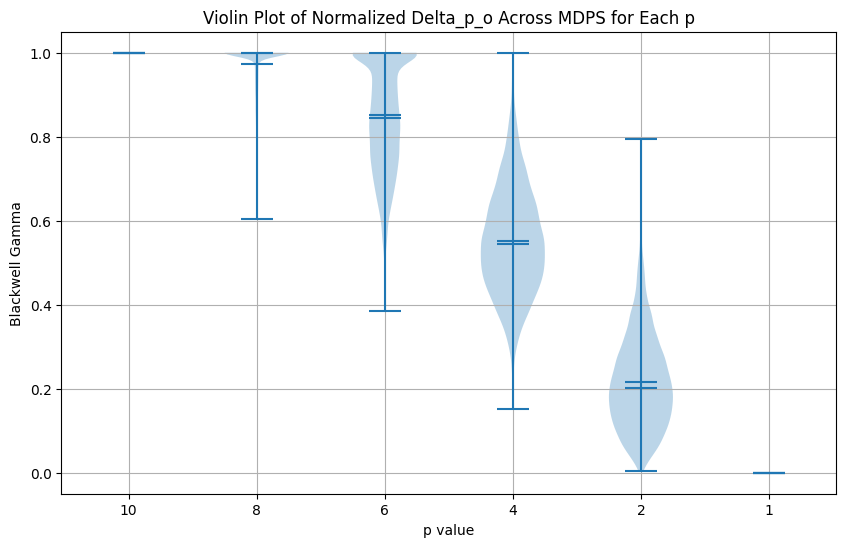

In [249]:
#normalize by dividing the parameter on each POMDP by the one on the state space.
normalized_delta_p_o = np.zeros((len(all_pomdps), len(omega_values)))
for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
    for p_idx, p in enumerate(omega_values):
        normalized_delta_p_o[pomdp_idx, p_idx] = delta_p_o[pomdp_idx, p_idx] / delta_p_s[pomdp_idx]

In [284]:
#This cell calculates the value-function variation for each POMDPs and their underlying MDPs.
gammas = np.linspace(0.0001,0.99,3)

state_values = np.zeros((len(gammas),len(all_pomdps), all_pomdps[0][0].mdp.num_states))
#kappa_s
kappa_gamma_s = np.zeros((len(gammas), len(all_pomdps)))
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[0].mdp.transitions, pomdp_instance[0].mdp.rewards,discount=gamma)
        pi.run()
        kappa_gamma_s[gamma_idx, pomdp_idx] = max(pi.V) - min(pi.V)
        state_values[gamma_idx, pomdp_idx, :] = pi.V


kappa_gamma_phi = np.zeros((len(gammas), len(all_pomdps), len(omega_values)))
#for each pomdps find the optimal values for each p
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for p_idx, p in enumerate(omega_values):
            pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards,discount=gamma)
            pi.run()
            kappa_gamma_phi[gamma_idx, pomdp_idx, p_idx] = max(pi.V) - min(pi.V)

In [251]:
#This cell calculates the bias for every POMDPs for varying values of gamma.

#You can set up the precision by changing the number of points in the linspace as long as the discount factor is between ]0,1[.
gammas_biases = np.linspace(0.0001,0.99,100)

bias = np.zeros((len(gammas_biases), len(all_pomdps), len(omega_values)))

# Now calculate the relative losses
for p_idx, p in enumerate(omega_values):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for gamma_idx, gamma in enumerate(gammas_biases):
            if gamma_idx == 0:
                pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gammas_biases[-1])
                pi.run()
                Max_values = pi.V
            pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gamma)
            pi.run()
            policy_array = np.array(pi.policy)
            R_pi = pomdp_instance[p_idx].rewards[np.arange(pomdp_instance[p_idx].num_observations), policy_array]
            P_pi = pomdp_instance[p_idx].transitions[policy_array, np.arange(pomdp_instance[p_idx].num_observations), :]
            V_pi_lowgamm = np.linalg.inv(np.eye(pomdp_instance[p_idx].num_observations) - gammas_biases[-1] * P_pi) @ R_pi
            bias[gamma_idx, pomdp_idx, p_idx] = np.max((Max_values - V_pi_lowgamm) / Max_values)



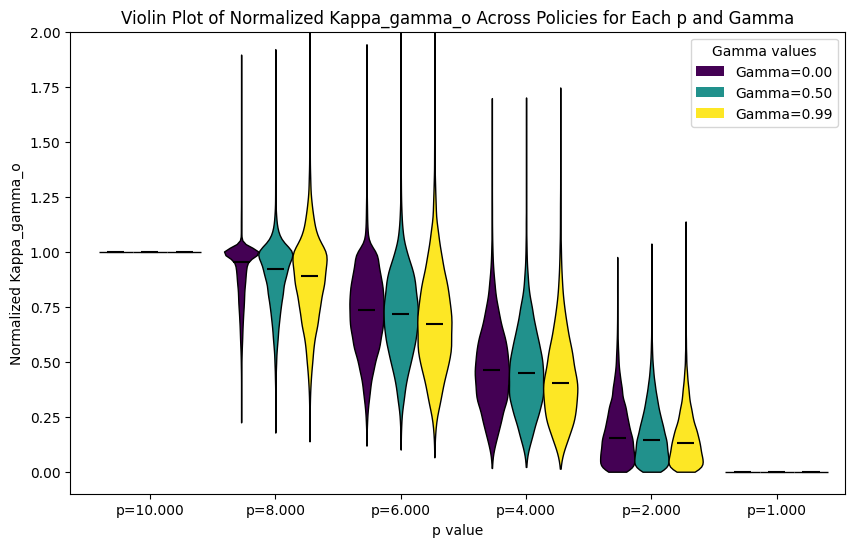

In [287]:
#Normalize the value-function variation for each POMDPs by the value of the parameter on the underlying MDP.
normalized_kappa_gamma = np.zeros((len(gammas), len(all_pomdps), len(omega_values)))
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for p_idx, p in enumerate(omega_values):
            normalized_kappa_gamma[gamma_idx, pomdp_idx, p_idx] = kappa_gamma_phi[gamma_idx, pomdp_idx, p_idx] / kappa_gamma_s[gamma_idx, pomdp_idx]


In [254]:
import mdptoolbox
import time
#Action gaps here, we need the Q-values
gammas = np.linspace(0.0001,0.99,2)

Q_s_a = np.zeros((len(gammas),len(all_pomdps), all_pomdps[0][0].mdp.num_states,all_pomdps[0][0].mdp.num_actions))
#kappa_s
kappa_gamma_s = np.zeros((len(gammas), len(all_pomdps)))
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[0].mdp.transitions, pomdp_instance[0].mdp.rewards,discount=gamma)
        pi.run()
        Q_s_a[gamma_idx, pomdp_idx, :, :] = pomdp_instance[0].mdp.rewards + np.einsum('ask,k->sa', pomdp_instance[0].mdp.transitions, pi.V)

        


Q_o_a = np.zeros((len(gammas),len(all_pomdps), len(omega_values), all_pomdps[0][0].num_observations,all_pomdps[0][0].mdp.num_actions))
#for each pomdps find the optimal values for each p
for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for p_idx, p in enumerate(omega_values):
            pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gamma)
            pi.run()
            Q_temp = pomdp_instance[p_idx].rewards + np.einsum('aok,k->oa', pomdp_instance[p_idx].transitions, pi.V)
            num_obs = Q_o_a.shape[3]  # Number of observations in the Q_o_a array
            Q_o_a[gamma_idx, pomdp_idx, p_idx, :Q_temp.shape[0], :] = Q_temp
            if Q_temp.shape[0] < num_obs:
                # Padding with zeros if the number of observations is less than required
                Q_o_a[gamma_idx, pomdp_idx, p_idx, Q_temp.shape[0]:, 0] = 0
                Q_o_a[gamma_idx, pomdp_idx, p_idx, Q_temp.shape[0]:, 1] = 10


In [255]:
#min action gap
action_gaps = np.zeros((len(gammas), len(all_pomdps), pomdp_instance[0].mdp.num_states))

for gamma_idx in range(len(gammas)):
    for pomdp_idx in range(len(all_pomdps)):
        for state_idx in range(pomdp_instance[0].mdp.num_states):
            max_q = np.max(Q_s_a[gamma_idx, pomdp_idx, state_idx, :])
            min_q = np.min(Q_s_a[gamma_idx, pomdp_idx, state_idx, :])
            action_gaps[gamma_idx, pomdp_idx, state_idx] = max_q - min_q

# Calculate the minimum action gap for Q_pi_o
action_gaps_o = np.zeros((len(gammas), len(all_pomdps), len(omega_values), pomdp_instance[0].num_observations))

for gamma_idx in range(len(gammas)):
    for pomdp_idx in range(len(all_pomdps)):
        for p_idx in range(len(omega_values)):
            for obs_idx in range(pomdp_instance[0].num_observations):
                max_q_o = np.max(Q_o_a[gamma_idx, pomdp_idx, p_idx, obs_idx, :])
                min_q_o = np.min(Q_o_a[gamma_idx, pomdp_idx, p_idx, obs_idx, :])
                action_gaps_o[gamma_idx, pomdp_idx, p_idx, obs_idx] = max_q_o - min_q_o



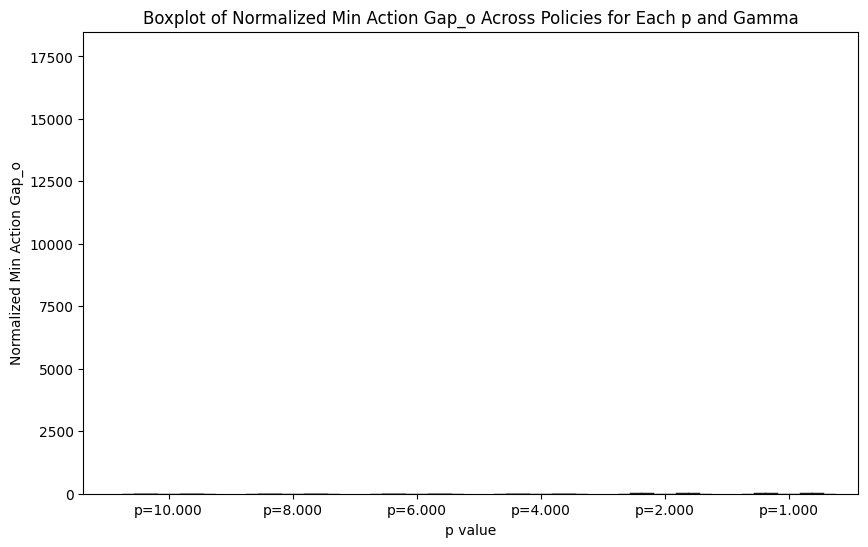

In [256]:
# Normalize min_action_gap_o by action_gaps
normalized_min_action_gap_o = np.zeros((len(gammas), len(all_pomdps), len(omega_values)))

for gamma_idx, gamma in enumerate(gammas):
    for pomdp_idx, pomdp_instance in enumerate(all_pomdps):
        for p_idx, p in enumerate(omega_values):
            normalized_min_action_gap_o[gamma_idx, pomdp_idx, p_idx] = np.min(action_gaps_o[gamma_idx, pomdp_idx, p_idx]) / np.min(action_gaps[gamma_idx, pomdp_idx])  # Dividing by the minimum action gap across all states

# Plotting a boxplot for each p value, splitting by gamma
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(gammas)))
positions = []
labels = []
width = 0.15  # width of the boxplots, can be adjusted for better visualization

# Adjust the spacing between groups of boxplots for each p value
group_width = len(gammas) * width + 0.1  # Adding some space between groups

for p_idx, p in enumerate(omega_values):
    base_position = p_idx * group_width  # Start position for each group
    positions.extend([base_position + gamma_idx * width for gamma_idx in range(len(gammas))])
    labels.append(f'p={p:.3f}')
    for gamma_idx, gamma in enumerate(gammas):
        pos = base_position + gamma_idx * width
        plt.boxplot(normalized_min_action_gap_o[gamma_idx, :, p_idx], positions=[pos], widths=width, patch_artist=True, boxprops=dict(facecolor=colors[gamma_idx], alpha=0.75), showfliers=False)

plt.title('Boxplot of Normalized Min Action Gap_o Across Policies for Each p and Gamma')
plt.xlabel('p value')
plt.ylabel('Normalized Min Action Gap_o')
plt.ylim(-0.1, np.max(normalized_min_action_gap_o))
plt.xlim(-0.2, len(omega_values) * group_width - 0.1)
plt.xticks([p_idx * group_width + (len(gammas) - 1) * width / 2 for p_idx in range(len(omega_values))], labels)
plt.show()


In [257]:
#Gamma blackwell as a function of p
gammas_for_bw = np.linspace(0.99, 0.0001, 100)  # Declare gammas in reverse order directly

blackwell_gammas = np.zeros((len(all_pomdps), len(omega_values)))

from joblib import Parallel, delayed

def process_pomdp(pomdp_instance, p_idx, p, gammas):
    last_policy = None
    for gamma_idx, gamma in enumerate(gammas_for_bw):  # Iterate through gammas normally since it's already reversed
        pi = mdptoolbox.mdp.PolicyIteration(pomdp_instance[p_idx].transitions, pomdp_instance[p_idx].rewards, discount=gamma)
        pi.run()
        if last_policy is not None and not np.array_equal(pi.policy, last_policy):
            break
        last_policy = pi.policy
        gamma_value = gamma
    return gamma_value

results = Parallel(n_jobs=-1)(delayed(process_pomdp)(pomdp_instance, p_idx, p, gammas) for pomdp_idx, pomdp_instance in enumerate(all_pomdps) for p_idx, p in enumerate(omega_values))

# Assign results back to blackwell_gammas
for idx, result in enumerate(results):
    pomdp_idx = idx // len(omega_values)
    p_idx = idx % len(omega_values)
    blackwell_gammas[pomdp_idx, p_idx] = result

for pomdp_idx in range(len(all_pomdps)):
    print("mdp done:", pomdp_idx)


mdp done: 0
mdp done: 1
mdp done: 2
mdp done: 3
mdp done: 4
mdp done: 5
mdp done: 6
mdp done: 7
mdp done: 8
mdp done: 9
mdp done: 10
mdp done: 11
mdp done: 12
mdp done: 13
mdp done: 14
mdp done: 15
mdp done: 16
mdp done: 17
mdp done: 18
mdp done: 19
mdp done: 20
mdp done: 21
mdp done: 22
mdp done: 23
mdp done: 24
mdp done: 25
mdp done: 26
mdp done: 27
mdp done: 28
mdp done: 29
mdp done: 30
mdp done: 31
mdp done: 32
mdp done: 33
mdp done: 34
mdp done: 35
mdp done: 36
mdp done: 37
mdp done: 38
mdp done: 39
mdp done: 40
mdp done: 41
mdp done: 42
mdp done: 43
mdp done: 44
mdp done: 45
mdp done: 46
mdp done: 47
mdp done: 48
mdp done: 49
mdp done: 50
mdp done: 51
mdp done: 52
mdp done: 53
mdp done: 54
mdp done: 55
mdp done: 56
mdp done: 57
mdp done: 58
mdp done: 59
mdp done: 60
mdp done: 61
mdp done: 62
mdp done: 63
mdp done: 64
mdp done: 65
mdp done: 66
mdp done: 67
mdp done: 68
mdp done: 69
mdp done: 70
mdp done: 71
mdp done: 72
mdp done: 73
mdp done: 74
mdp done: 75
mdp done: 76
mdp done:

In [258]:
import matplotlib.pyplot as plt

# Assuming 'omega_values' and 'blackwell_gammas' are defined in the scope as per previous cells
plt.figure(figsize=(10, 6))
# Plotting the violin plot of Blackwell gammas over randomly generated POMDPs (first axis)
# with omega_values on the x-axis (second axis of blackwell_gammas)
plt.violinplot(blackwell_gammas, positions=range(len(omega_values)), showmeans=True, showextrema=True, showmedians=True)
plt.xticks(range(len(omega_values)), omega_values)
plt.ylabel('$\gamma_{Bw}$', fontsize=14)
plt.xlabel('$N_O$', fontsize=14)
# Save the plot as a PDF file
plt.savefig("Blackwell_Gammas_Violin_Plot.pdf", format='pdf')
plt.close()

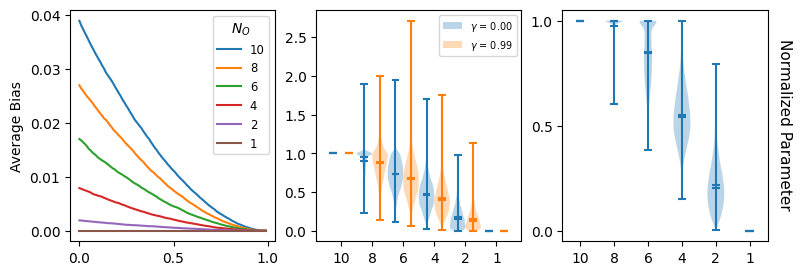

In [259]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))  # Create a figure with 1 row and 3 columns

# Common settings for all plots
plot_settings = {
    'showmeans': True,
    'showextrema': True,
    'showmedians': True
}

# Replacing the first plot with the requested plot from file_context_0
for p_idx, p in enumerate(omega_values):
    axs[0].plot(gammas_biases, bias[:, :, p_idx].mean(axis=1), label=p)
axs[0].set_ylabel('Average Bias')
axs[0].legend(title="$N_O$", fontsize='small')  # Reduced the size of the legend

# Assuming 'normalized_kappa_gamma', 'gammas', and 'omega_values' are defined
# 'normalized_kappa_gamma' should be a list of lists, where each sublist corresponds to a gamma value for each p
violin_parts = []
for i, gamma in enumerate(gammas):
    positions = [p + i * 0.5 for p in range(len(omega_values))]  # Increase offset for each gamma's violins for better clarity and separation
    vp = axs[1].violinplot(normalized_kappa_gamma[i], positions=positions, **plot_settings)
    violin_parts.append(vp)
axs[1].set_xticks([p + (len(gammas) - 1) * 0.25 for p in range(len(omega_values))])  # Adjust center ticks to align with the increased separation of violins
axs[1].set_xticklabels(omega_values)
axs[1].set_ylabel('')

# Create legend for the gammas with even smaller font size
labels = [f'$\gamma$ = {gamma:.2f}' for gamma in gammas]
axs[1].legend([vp["bodies"][0] for vp in violin_parts], labels, loc='upper right', fontsize='x-small')

# Assuming 'normalized_delta_p_o', 'omega_values' are defined
axs[2].violinplot(normalized_delta_p_o, positions=range(len(omega_values)), **plot_settings)
axs[2].set_xticks(range(len(omega_values)))
axs[2].set_xticklabels(omega_values)
axs[2].set_ylabel('')
axs[2].set_yticks(np.arange(0, 1.1, 0.5))

fig.text(0.91, 0.5, 'Normalized Parameter', va='center', rotation=-90, fontsize=11)

plt.savefig("plots.pdf", format='pdf')  # Save the figure as a PDF file


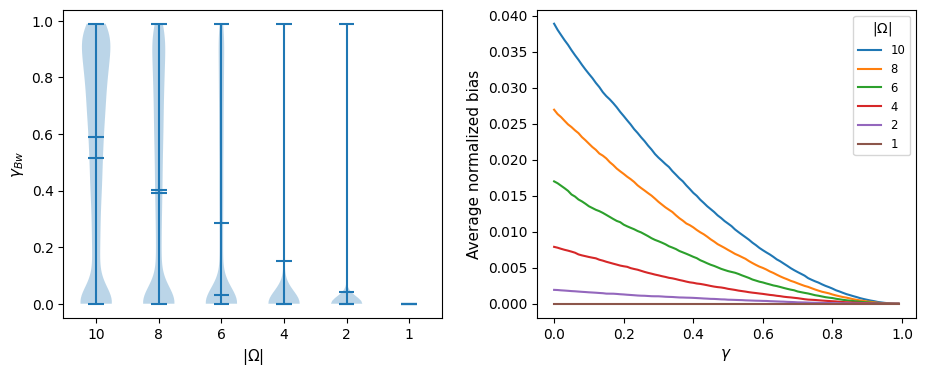

In [311]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(11, 4), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.25})  # Create a figure with 1 row and 2 columns, increased figure width and added space between plots

# Assuming 'omega_values' and 'blackwell_gammas' are defined in the scope as per previous cells
# Plotting the violin plot of Blackwell gammas over randomly generated POMDPs (first axis)
# with omega_values on the x-axis (second axis of blackwell_gammas)
axs[0].violinplot(blackwell_gammas, positions=range(len(omega_values)), showmeans=True, showextrema=True, showmedians=True)
axs[0].set_xticks(range(len(omega_values)))
axs[0].set_xticklabels(omega_values)
axs[0].set_ylabel('$\gamma_{Bw}$', fontsize=11)
axs[0].set_xlabel('$|\Omega|$', fontsize=11)

# Common settings for all plots
plot_settings = {
    'showmeans': True,
    'showextrema': True,
    'showmedians': True
}

# Replacing the first plot with the requested plot from file_context_0
for p_idx, p in enumerate(omega_values):
    axs[1].plot(gammas_biases, bias[:, :, p_idx].mean(axis=1), label=p)
axs[1].set_ylabel('Average normalized bias', fontsize=11)
axs[1].legend(title="$|\Omega|$", fontsize='small')  # Reduced the size of the legend
axs[1].set_xlabel('$\gamma$', fontsize=11)
# Save the figure as a PDF file
plt.savefig("Combined_Plots_bias.pdf", format='pdf')
plt.show()
plt.close()


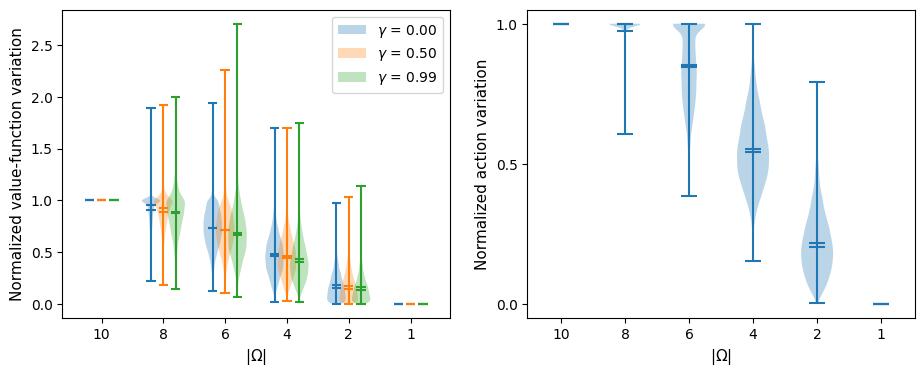

In [306]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'normalized_kappa_gamma', 'gammas', and 'omega_values' are defined
# 'normalized_kappa_gamma' should be a list of lists, where each sublist corresponds to a gamma value for each p
fig, axs = plt.subplots(1, 2, figsize=(11, 4))  # Create a figure with 1 row and 2 columns

violin_parts = []
offset_increment = 0.2 # Reduced increment to minimize overlap and adjust density
for i, gamma in enumerate(gammas):
    positions = [p + i * offset_increment for p in range(len(omega_values))]  # Adjusted offset for each gamma's violins for better clarity and separation
    vp = axs[0].violinplot(normalized_kappa_gamma[i], positions=positions, **plot_settings, widths=0.3)  # Reduced violin width for better fit
    violin_parts.append(vp)
axs[0].set_xticks([p + (len(gammas) - 1) * 0.2 / 2 for p in range(len(omega_values))])  # Center ticks adjusted to new offset and spacing
axs[0].set_xticklabels(omega_values)
axs[0].set_ylabel('Normalized value-function variation', fontsize=11)
axs[0].set_xlabel('$|\Omega|$', fontsize=11)

# Create legend for the gammas with even smaller font size
labels = [f'$\gamma$ = {gamma:.2f}' for gamma in gammas]
axs[0].legend([vp["bodies"][0] for vp in violin_parts], labels, loc='upper right', fontsize=10)

# Assuming 'normalized_delta_p_o', 'omega_values' are defined
axs[1].violinplot(normalized_delta_p_o, positions=range(len(omega_values)), **plot_settings)
axs[1].set_xticks(range(len(omega_values)))
axs[1].set_xticklabels(omega_values)
axs[1].set_ylabel('Normalized action variation', fontsize=11)
axs[1].set_yticks(np.arange(0, 1.1, 0.5))
axs[1].set_xlabel('$|\Omega|$', fontsize=11)

plt.savefig("Combined_Plots_params.pdf", format='pdf')
plt.show()
plt.close()


In [314]:
import matplotlib.pyplot as plt

# Plot 1: Blackwell Gammas Violin Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.violinplot(blackwell_gammas, positions=range(len(omega_values)), showmeans=True, showextrema=True, showmedians=True)
ax.set_xticks(range(len(omega_values)))
ax.set_xticklabels(omega_values)
ax.set_ylabel('$\gamma_{Bw}$', fontsize=11)
ax.set_xlabel('$|\Omega|$', fontsize=11)
plt.savefig("individual_plots/Blackwell_Gammas_Violin_Plot.pdf", format='pdf')
plt.close()

# Plot 2: Average Normalized Bias
fig, ax = plt.subplots(figsize=(6, 4))
for p_idx, p in enumerate(omega_values):
    ax.plot(gammas_biases, bias[:, :, p_idx].mean(axis=1), label=p)
ax.set_ylabel('Average normalized bias', fontsize=11)
ax.legend(title="$|\Omega|$", fontsize='small')
ax.set_xlabel('$\gamma$', fontsize=11)
plt.savefig("individual_plots/Average_Normalized_Bias.pdf", format='pdf')
plt.close()

# Plot 3: Normalized Value-Function Variation Violin Plot
fig, ax = plt.subplots(figsize=(6, 4))
offset_increment = 0.2
violin_parts = []
for i, gamma in enumerate(gammas):
    positions = [p + i * offset_increment for p in range(len(omega_values))]
    vp = ax.violinplot(normalized_kappa_gamma[i], positions=positions, showmeans=True, showextrema=True, showmedians=True, widths=0.3)
    violin_parts.append(vp)
ax.set_xticks([p + (len(gammas) - 1) * 0.2 / 2 for p in range(len(omega_values))])
ax.set_xticklabels(omega_values)
ax.set_ylabel('Normalized value-function variation', fontsize=11)
ax.set_xlabel('$|\Omega|$', fontsize=11)
labels = [f'$\gamma$ = {gamma:.2f}' for gamma in gammas]
ax.legend([vp["bodies"][0] for vp in violin_parts], labels, loc='upper right', fontsize=10)
plt.savefig("individual_plots/Normalized_Value_Function_Variation_Violin_Plot.pdf", format='pdf')
plt.close()

# Plot 4: Normalized Action Variation Violin Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.violinplot(normalized_delta_p_o, positions=range(len(omega_values)), showmeans=True, showextrema=True, showmedians=True)
ax.set_xticks(range(len(omega_values)))
ax.set_xticklabels(omega_values)
ax.set_ylabel('Normalized action variation', fontsize=11)
ax.set_yticks(np.arange(0, 1.1, 0.5))
ax.set_xlabel('$|\Omega|$', fontsize=11)
plt.savefig("individual_plots/Normalized_Action_Variation_Violin_Plot.pdf", format='pdf')
plt.close()